In [0]:
import torch
import matplotlib.pyplot as plt
import torchvision as tv 
import cv2
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import pathlib
import re
from torch.utils.data import Dataset, DataLoader
import more_itertools as mit
from statistics import median, mean
import nltk
from nltk import FreqDist
from collections import Counter
from itertools import chain

In [0]:
# this two lines are for unzip file
# !tar xzf drive/My\ Drive/alcon2019.tar.gz

In [0]:
# !cd alcon2019/dataset/train_kana
# !find . -name ".*.jpg" -type f -delete

In [0]:
# kana initial parameters
kana_dir = 'alcon2019/dataset/train_kana'
three_train_dir = 'alcon2019/dataset/train/imgs/'
three_train_label_csv = 'alcon2019/dataset/train/annotations.csv'
three_test_dir = 'alcon2019/dataset/test/imgs/'
batch_size = 32
num_workers = 4
num_epochs = 5
kana_norm = ([0.61], [0.22])
train_norm = ([0.56], [0.22])
test_norm = ([0.42], [0.20])
resize_size = (64, 64)

kana_transform = tv.transforms.Compose([
        tv.transforms.Grayscale(),
        tv.transforms.Resize(resize_size),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(*kana_norm)
    ])

# three kana initial parameters
three_transform = tv.transforms.Compose([
        tv.transforms.Grayscale(),
        tv.transforms.Resize(resize_size)
])
filter_proj_count = 2
line_width_min_limit = 0
pixel_min = 20
binary_boundary = 140
sep_distance_thresh = 30    
closet_line_rate = 0.13
classes = ['U+3042', 'U+3044', 'U+3046', 'U+3048', 'U+304A', 'U+304B', 'U+304D', 'U+304F', 
           'U+3051', 'U+3053', 'U+3055', 'U+3057', 'U+3059', 'U+305B', 'U+305D', 'U+305F', 
           'U+3061', 'U+3064', 'U+3066', 'U+3068', 'U+306A', 'U+306B', 'U+306C', 'U+306D', 
           'U+306E', 'U+306F', 'U+3072', 'U+3075', 'U+3078', 'U+307B', 'U+307E', 'U+307F', 
           'U+3080', 'U+3081', 'U+3082', 'U+3084', 'U+3086', 'U+3088', 'U+3089', 'U+308A', 
           'U+308B', 'U+308C', 'U+308D', 'U+308F', 'U+3090', 'U+3091', 'U+3092', 'U+3093']
num_kana_classes = len(classes)

In [0]:
"""
this is all the function and class definition
"""

class ThreeKanaDataset(Dataset):
    """Three characters train dataset."""
    
    def __init__(self, root_dir, norm, csv_file=None, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations(not necessary if it's test dir).
            transform (callable, optional): Optional transform to be applied on a sample.
            norm (tupple): for normalize
        """
        if csv_file:
            self.labels = np.array(pd.read_csv(csv_file)[["Unicode1", "Unicode2", "Unicode3"]])
            self.csv_file = csv_file
        else:
            self.csv_file = None
        train_root = pathlib.Path(root_dir)
        all_image_paths = [str(path) for path in list(train_root.glob('*'))]
        all_image_paths.sort(key=lambda x: int(re.findall(r'\d+(?=\.jpg)', x)[0]))
        self.all_image_paths = all_image_paths
        self.transform = transform
        self.norm = norm

    def __len__(self):
        return len(self.all_image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.all_image_paths[idx])
        self.img_gray = cv2.imread(self.all_image_paths[idx], cv2.IMREAD_GRAYSCALE)
        three_imgs = self.get_final_splitted_images(img)
        
        if self.transform:
            three_imgs = [self.transform(tv.transforms.functional.to_pil_image(x)) for x in three_imgs]
            transform_comp = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize(*self.norm)])
            three_imgs = torch.stack([transform_comp(crop) for crop in three_imgs])
        
        if self.csv_file:
            return {'image': three_imgs, 'label': self.labels[idx]}
        else:
            return {'image': three_imgs}
    
    def tackle_close_seps(self, arr):    
        global sep_distance_thresh 
        for _ in range(4):
            flag = 1
            discard = set()
            addition = set()
            for i in range(1, len(arr)):
                if arr[i] - arr[i-1] <= sep_distance_thresh:
                    flag = 0
                    discard.add(arr[i-1])
                    discard.add(arr[i])
                    addition.add(int((arr[i-1] + arr[i])/2))
            arr = sorted(list(set(arr).difference(discard).union(addition)))
            if flag == 1:
                break
        return arr
    
    def img_preprocess(self):
        _, thresh = cv2.threshold(self.img_gray, binary_boundary, 255, cv2.THRESH_BINARY_INV)
    #     kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)) 
        kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4)) 
    #     handled_1 = cv2.erode(thresh, kernel1, iterations = 1) # 先腐蚀
        handled_2 = cv2.dilate(thresh, kernel2, iterations = 1) # 再膨胀
        handled_2 = handled_2/255
        return handled_2
    
    def draw_seps(self, img, *args):
        lineThickness = 3
        for arg in args:
            cv2.line(img, (0, arg), (img.shape[1], arg), (255,0,0), lineThickness)
        # this is the code for draw horizontal projection 
        # plt.plot(proj, range(len(proj))[::-1])
        
    def get_proj(self, img):
        return np.sum(img, axis=1)

    def find_sep(self, arr:list):
        idx0, idx1 = pixel_min, len(arr) - pixel_min
        a = arr[idx0:idx1]
        zero_idx_arr = [i+idx0 for i, e in enumerate(a) if e <= filter_proj_count]
        group_arr = [list(group) for group in mit.consecutive_groups(zero_idx_arr)]
        return [int(median(x)) for x in group_arr if len(x) >= line_width_min_limit]

    def split_image(self, img, sep1, sep2):
        height, width, _ = img.shape
        crop_img1 = img[0:sep1, 0:width]
        crop_img2 = img[sep1:sep2, 0:width]
        crop_img3 = img[sep2:height, 0:width]
        return [crop_img1, crop_img2, crop_img3]


    def find_closest_line(self, height, arr):
        sep13, sep23 = int(height/3), int(height*2/3)
        thresh = height * closet_line_rate
        ans = []
        for line in arr:
            if abs(line - sep13) <= thresh or abs(line - sep23) <= thresh:
                ans.append(line)
        return ans

    def allow_max1line_1part(self, height, arr):
        middle = height/2
        up_part = [x for x in arr if x <= middle]
        down_part = [x for x in arr if x > middle]
        up_diff = [middle-x for x in up_part]
        down_diff = [x-middle for x in down_part]
        ans = []
        if up_diff:
            up_val = up_part[up_diff.index(min(up_diff))]
            ans.append(up_val)
        if down_diff:
            down_val = down_part[down_diff.index(min(down_diff))]
            ans.append(down_val)
        return ans

    def tackle_1sep(self, height, arr):
        value = arr[0]
        if value < height/2:
            arr.append(int((height - value) / 2) + value)
        else:
            arr.insert(0, int(value/2))
        return arr

    def get_final_seps(self, img):   
        height = img.shape[0]
        handled = self.img_preprocess()
        proj = self.get_proj(handled)
        seps = self.find_sep(proj)
        seps = self.tackle_close_seps(seps)
        if len(seps) > 1:
            seps = self.find_closest_line(height, seps)
        seps = self.allow_max1line_1part(height, seps)
        if len(seps) == 1:
            seps = self.tackle_1sep(height, seps)
        elif len(seps) == 0:
            seps = [int(height/3), int(height*2/3)]
        return seps

    def get_final_splitted_images(self, img):
        seps = self.get_final_seps(img)
        return self.split_image(img, *seps)
      
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_kana_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      


def train_model():
    model.train()
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_dataset_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    
def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))
    model.eval()   
    
def show_kana_accuracy():
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in kana_test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            softmax_arr = nn.functional.softmax(outputs.data, dim=1)
            _, predicted = torch.max(softmax_arr, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    
def show_each_kana_accuracy():
    class_correct = list(0. for _ in range(num_kana_classes))
    class_total = list(0. for _ in range(num_kana_classes))
    with torch.no_grad():
        for data in kana_test_loader:
            images, labels = data
            images_, labels_ = images.to(device), labels.to(device)
            outputs = model(images_)
            softmax_arr = nn.functional.softmax(outputs.data, dim=1)
            _, predicted = torch.max(softmax_arr, 1)
            c = (predicted == labels_).squeeze()
            for i in range(labels.size(0)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(num_kana_classes):
        print('Accuracy of %5s : %2d %%' % (
            kana_dataset.classes[i], 100 * class_correct[i] / class_total[i]))   
        
def show_splitted_three_imgs():
  for i in range(len(three_train_dataset)):
      sample = three_train_dataset[i]
      plt.figure(i, figsize=(4,4))
      for j in range(len(sample['image'])):      
          plt.subplot(1, 3, j + 1)
          plt.imshow(sample['image'][j].numpy()[0])
          plt.title(str(sample['label'][j]))

      if i == 3:
          plt.show()
          break      
          
# only applicable for three kana
def calculate_mean_std(dataset):
    pop_mean = []
    pop_std0 = []
    pop_std1 = []
    for i in range(len(dataset)):
        # shape (batch_size, 3, height, width)
        data = dataset[i]
        numpy_image = data['image'].numpy()

        # shape (3,)
        batch_mean = np.mean(numpy_image, axis=(0,2,3))
        batch_std0 = np.std(numpy_image, axis=(0,2,3))
        batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)

        pop_mean.append(batch_mean)
        pop_std0.append(batch_std0)
        pop_std1.append(batch_std1)

    # shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
    pop_mean = np.array(pop_mean).mean(axis=0)
    pop_std0 = np.array(pop_std0).mean(axis=0)
    pop_std1 = np.array(pop_std1).mean(axis=0)
    print(pop_mean, pop_std0, pop_std1)       
    
def show_kana_sample():
    for i_batch, sample_batched in enumerate(kana_train_loader):
        print(i_batch, sample_batched[0].size(), sample_batched[1].size())

        # observe 4th batch and stop.
        if i_batch == 3:
            plt.figure()
            grid = tv.utils.make_grid(sample_batched[0])
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.axis('off')
            plt.ioff()
            plt.show()
            break
            
            
def show_three_train_accuracy():
    correct = 0
    total = 0
    predicted_label_arr = []
    predicted_prob_arr = []
    with torch.no_grad():
        for i in range(len(three_train_dataset)):
            sample = three_train_dataset[i]
            images, label = sample['image'], sample['label']
            images = images.to(device)
            outputs = model(images)
            softmax_arr = nn.functional.softmax(outputs.data, dim=1)
#             prob, predicted = torch.max(softmax_arr, 1)
            prob_top3, predicted_top3 = torch.topk(softmax_arr, 3)
            adjust_predicted, adjust_prob = adjust_by_ngram(prob_top3, predicted_top3)
            adjust_predicted = [classes[i] for i in adjust_predicted]
            predicted_label_arr.append(adjust_predicted)
            predicted_prob_arr.append(adjust_prob)
            total += 1
            if list(adjust_predicted) == list(label):
                correct += 1

    print('Accuracy of the network on the three train images: %d %%' % (100 * correct / total))
    return predicted_label_arr, predicted_prob_arr
    
    
def show_three_single_accuracy(predicted_arr):
    train_labels = np.array(pd.read_csv(three_train_label_csv)[["Unicode1", "Unicode2", "Unicode3"]]).flatten()
    predicted_arr = np.array(predicted_arr).flatten()
    accuracy_splitted_single = (train_labels == predicted_arr).sum() / len(predicted_arr) * 100
    print('Accuracy of splitted single character: %d %%' % round(accuracy_splitted_single))
    
    
def get_test_answer():
    predicted_label_arr = []
    predicted_prob_arr = []
    with torch.no_grad():
        for i in range(len(three_test_dataset)):
            sample = three_test_dataset[i]
            images= sample['image'].to(device)
            outputs = model(images)
            softmax_arr = nn.functional.softmax(outputs.data, dim=1)
#             _, predicted = torch.max(softmax_arr, 1)
            prob_top3, predicted_top3 = torch.topk(softmax_arr, 3)
            adjust_predicted, adjust_prob = adjust_by_ngram(prob_top3, predicted_top3)
            adjust_predicted = [classes[i] for i in adjust_predicted]
            predicted_label_arr.append(adjust_predicted)
            predicted_prob_arr.append(adjust_prob)
    analysis_probs(predicted_prob_arr)
    return predicted_label_arr, predicted_prob_arr

def write_to_csv(arr, path):
    a = arr[::]
    for i in range(len(a)):
      a[i].insert(0, i)
    pd.DataFrame(a, columns=['ID', 'Unicode1', 'Unicode2', 'Unicode3']).to_csv(path, index=False)   
    
def adjust_by_ngram(prob_top3, predicted_top3):
    adjust_prob = [None]*3 
    adjust_predicted = [None]*3 
    for j, p_arr in enumerate(prob_top3):
        if p_arr[0] < 0.3:
            kana, prob = find_max_kana(j, prob_top3, predicted_top3)
            if prob > 0:
                adjust_predicted[j] = kana
                adjust_prob[j] = prob
        if adjust_prob[j] == None:
            adjust_prob[j] = prob_top3[j][0].item()
            adjust_predicted[j] = predicted_top3[j][0].item()
    return adjust_predicted, adjust_prob
  
def get_fredict():
    df = pd.read_csv("alcon2019/dataset/train/annotations.csv")
    u_data = df[["Unicode1", "Unicode2", "Unicode3"]].values.tolist()
    
    # get unigram frequency dict
    u_data_unigram = np.array(u_data).flatten().tolist()
    fdict_unigram = dict(FreqDist(u_data_unigram).most_common())
    for k, v in fdict_unigram.items():
        fdict_unigram[k] = round(v/len(u_data_unigram), 5)
        
    # get bigram frequency dict
    u_data_bigram = []
    for x in u_data:
        u_data_bigram.extend(nltk.bigrams(x))
    fdict_bigram = dict(Counter(u_data_bigram).most_common())
    for k, v in fdict_bigram.items():
        fdict_bigram[k] = round(v/len(u_data_bigram), 5)
        
    # get trigram frequency dict
    fdict_trigram = dict(Counter([tuple(x) for x in u_data]).most_common())
    for k, v in fdict_trigram.items():
        fdict_trigram[k] = round(v/len(u_data), 5)
        
    return fdict_unigram, fdict_bigram, fdict_trigram

def prob_between(former_c:str, latter_c:str):
    if (former_c, latter_c) in fdict_bigram.keys():
        return fdict_bigram[(former_c, latter_c)]
    else:
        return 0
      
      
def analysis_probs(probs):
    probs = torch.tensor(probs)
    print("median: {0}, mean: {1}, min: {2}, max: {3}".format(torch.median(probs), torch.mean(probs), 
                                                              torch.min(probs), torch.max(probs)))    
    
def find_max_kana(idx, p_arr, label_idx):
    max_kana_idx = max_prob = -1
    if idx == 0:
        if p_arr[0][0] < p_arr[1][0]:
            for i in range(len(p_arr)):  
                prob = 5*prob_between(classes[int(label_idx[0][i].item())], classes[int(label_idx[1][0].item())]) + 0.3*int(p_arr[0][i].item()) + 1*fdict_unigram[classes[int(label_idx[0][i].item())]]
                if prob > max_prob:
                    max_prob = prob
                    max_kana_idx = i
    elif idx == 1:
        if p_arr[1][0] < p_arr[0][0]:
            for i in range(len(p_arr)):              
                prob = 5*prob_between(classes[int(label_idx[0][0].item())], classes[int(label_idx[1][i].item())]) + 0.3*int(p_arr[1][i].item()) + 1*fdict_unigram[classes[int(label_idx[1][i].item())]]
                if prob > max_prob:
                    max_prob = prob
                    max_kana_idx = i
        if p_arr[1][0] < p_arr[2][0]:
            for i in range(len(p_arr)):              
                prob = 5*prob_between(classes[int(label_idx[1][i].item())], classes[int(label_idx[2][0].item())]) + 0.3*int(p_arr[1][i].item()) + 1*fdict_unigram[classes[int(label_idx[1][i].item())]]
                if prob > max_prob:
                    max_prob = prob
                    max_kana_idx = i
    elif idx == 2:
        if p_arr[2][0] < p_arr[1][0]:
            for i in range(len(p_arr)):              
                prob = 5*prob_between(classes[int(label_idx[1][0].item())], classes[int(label_idx[2][i].item())]) + 0.3*int(p_arr[2][i].item()) + 1*fdict_unigram[classes[int(label_idx[2][i].item())]]
                if prob > max_prob:
                    max_prob = prob
                    max_kana_idx = i
    return max_kana_idx, max_prob

In [0]:
# kana dataset
kana_dataset = tv.datasets.ImageFolder(root=kana_dir, transform=kana_transform)
kana_train_size = int(0.8 * len(kana_dataset))
kana_test_size = len(kana_dataset) - kana_train_size
kana_train_dataset, kana_test_dataset = torch.utils.data.random_split(kana_dataset, [kana_train_size, kana_test_size])
kana_train_loader = torch.utils.data.DataLoader(kana_train_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=num_workers)

kana_test_loader = torch.utils.data.DataLoader(kana_test_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=num_workers)

# three kana dataset
three_train_dataset = ThreeKanaDataset(csv_file=three_train_label_csv, norm=train_norm, root_dir=three_train_dir, transform=three_transform)
three_test_dataset = ThreeKanaDataset(root_dir=three_test_dir, norm=test_norm, transform=three_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([32, 1, 64, 64]) torch.Size([32])
1 torch.Size([32, 1, 64, 64]) torch.Size([32])
2 torch.Size([32, 1, 64, 64]) torch.Size([32])
3 torch.Size([32, 1, 64, 64]) torch.Size([32])


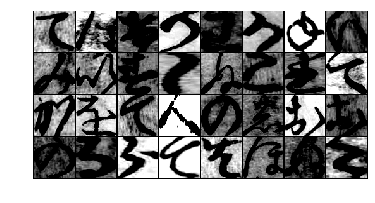

In [10]:
show_kana_sample()

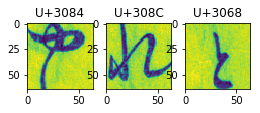

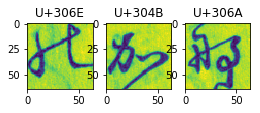

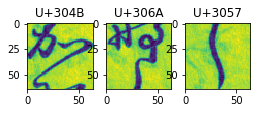

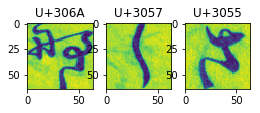

In [14]:
show_splitted_three_imgs()

In [0]:
model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [22]:
# train_model()
model.load_state_dict(torch.load('drive/My Drive/kana_cnn_95.pt'))
model.eval()


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=48, bias=True)
)

In [25]:
show_kana_accuracy()

Accuracy of the network on the test images: 97 %


In [28]:
show_each_kana_accuracy()

Accuracy of U+3042 : 99 %
Accuracy of U+3044 : 98 %
Accuracy of U+3046 : 97 %
Accuracy of U+3048 : 92 %
Accuracy of U+304A : 99 %
Accuracy of U+304B : 91 %
Accuracy of U+304D : 97 %
Accuracy of U+304F : 95 %
Accuracy of U+3051 : 96 %
Accuracy of U+3053 : 95 %
Accuracy of U+3055 : 96 %
Accuracy of U+3057 : 97 %
Accuracy of U+3059 : 97 %
Accuracy of U+305B : 97 %
Accuracy of U+305D : 94 %
Accuracy of U+305F : 96 %
Accuracy of U+3061 : 90 %
Accuracy of U+3064 : 96 %
Accuracy of U+3066 : 98 %
Accuracy of U+3068 : 98 %
Accuracy of U+306A : 97 %
Accuracy of U+306B : 98 %
Accuracy of U+306C : 94 %
Accuracy of U+306D : 97 %
Accuracy of U+306E : 98 %
Accuracy of U+306F : 97 %
Accuracy of U+3072 : 98 %
Accuracy of U+3075 : 98 %
Accuracy of U+3078 : 97 %
Accuracy of U+307B : 95 %
Accuracy of U+307E : 97 %
Accuracy of U+307F : 94 %
Accuracy of U+3080 : 96 %
Accuracy of U+3081 : 96 %
Accuracy of U+3082 : 97 %
Accuracy of U+3084 : 98 %
Accuracy of U+3086 : 91 %
Accuracy of U+3088 : 98 %
Accuracy of 

In [0]:
fdict_unigram, fdict_bigram, fdict_trigram = get_fredict()

In [30]:
three_train_predicted_labels, three_train_predicted_probs = show_three_train_accuracy()

Accuracy of the network on the three train images: 27 %


In [33]:
show_three_single_accuracy(three_train_predicted_labels)

Accuracy of splitted single character: 63 %


In [34]:
test_predicted_labels, test_predicted_prob = get_test_answer()

median: 0.8559626936912537, mean: 0.7587478160858154, min: 0.011669999919831753, max: 1.0


In [35]:
test_predicted_labels[:2]

[['U+306B', 'U+304B', 'U+3089'], ['U+304B', 'U+3046', 'U+308C']]

In [0]:
# save_model(model, 'kana_cnn_95.pt')

In [0]:
write_to_csv(test_predicted_labels, "test_prediction.csv")